In [1]:
import glob 
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.distributions import Laplace, Normal
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from datetime import datetime

import poisevae
from poisevae.datasets import MNIST_GM
from poisevae.networks.MNISTGMNetworks import EncMNIST, DecMNIST, EncGM, DecGM

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')

In [5]:
lat1, lat2 = 2, 2
emb_dim = 8
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_gm = EncGM(2, emb_dim, lat2).to(device)
dec_gm = DecGM(2, emb_dim, lat2).to(device)

vae = poisevae.POISEVAE([enc_mnist, enc_gm], [dec_mnist, dec_gm], likelihoods=[Laplace, Normal], 
                        latent_dims=[lat1, lat2], reduction='mean').to(device)

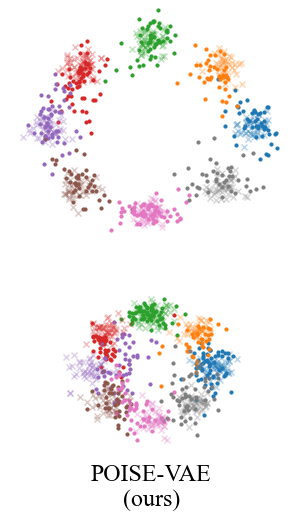

In [20]:
idx = (5, 3)
fig, ax = plt.subplots(len(idx), figsize=(4, 3.5*len(idx)), sharex='all', sharey='all')
with torch.no_grad():
    for j, rad in enumerate(idx):
        path = '../example/runs/MNIST_GM/rad%d_%d/' % (rad, np.random.randint(10))
        vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(path + 'train*.pt'))[-1])
        assert epoch == 40
        joint_dataset_test = MNIST_GM(mnist_pt_path=MNIST_PATH % 'test', data_augment=1, radius=rad)
        test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=400, shuffle=True, drop_last=True)
        for i, data in enumerate(test_loader):
            results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
            break
        x_rec = results['x_rec']
        if isinstance(x_rec[0], torch.distributions.Distribution):
            x_rec = [x_rec[0].loc, x_rec[1].loc]

        for i in range(0, 8):
            ax[j].scatter(*x_rec[1][data[-1]==i+1].detach().cpu().numpy().T, c='C%d'%i, s=10, zorder=2)
            ax[j].scatter(*data[1][data[-1]==i+1].detach().cpu().numpy().T, c='C%d'%i, alpha=0.3, marker='x', zorder=3)
            ax[j].set_xlim([-7, 7])
            ax[j].set_ylim([-7, 7])
            ax[j].set_axis_off()
        # ax[j].set_xticks([])
        # ax[j].set_yticks([])
ax[-1].text(0.0, -7, 'POISE-VAE\n(ours)', fontsize=24, va='center', ha='center')
        # ax.plot([], [], marker='.', c='k', alpha=1, label='Rec.', linewidth=0)
        # ax.plot([], [], marker='x', c='k', alpha=1, label='Truth', linewidth=0)
        # fig.legend(fontsize='small', loc=(0.71, 0.11), ncol=1, handletextpad=0, labelspacing=0)
fig.tight_layout(pad=0)
fig.savefig(os.path.join('../example/runs/MNIST_GM/', 'poisevae_without_rec_reweighting.pdf'), dpi=300)

/tmp/ipykernel_3411839/1847453792.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))


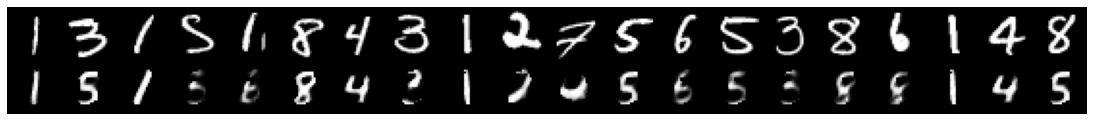

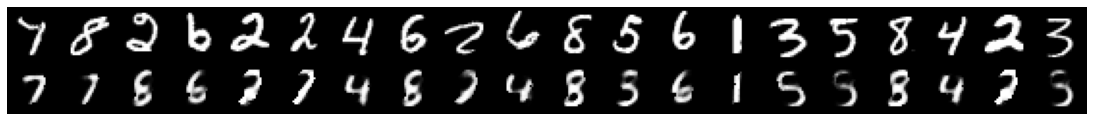

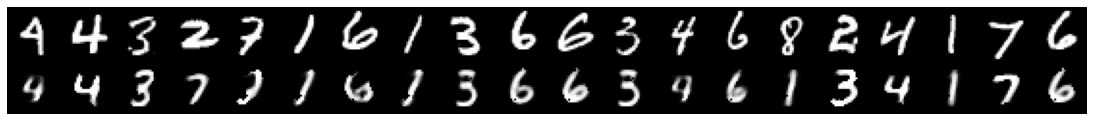

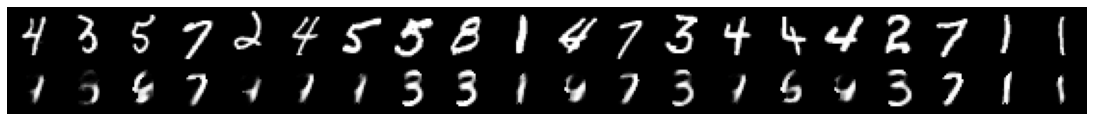

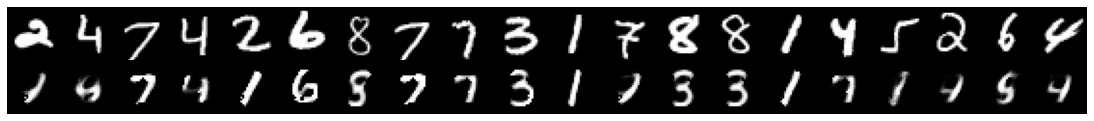

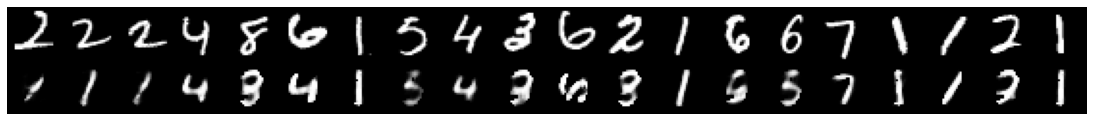

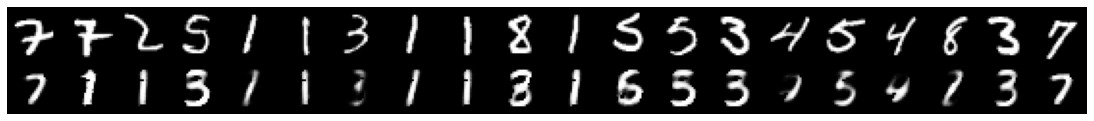

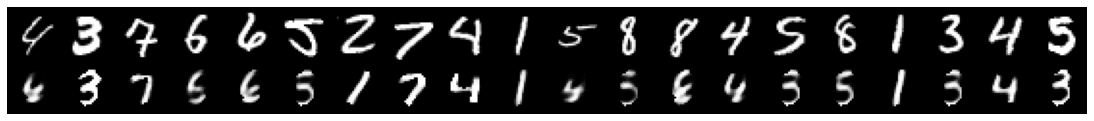

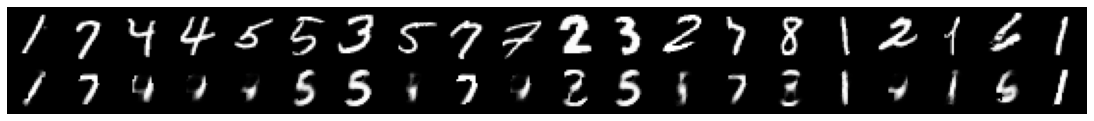

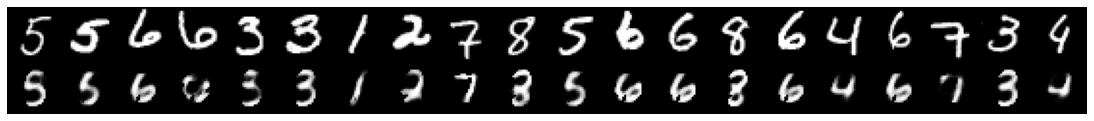

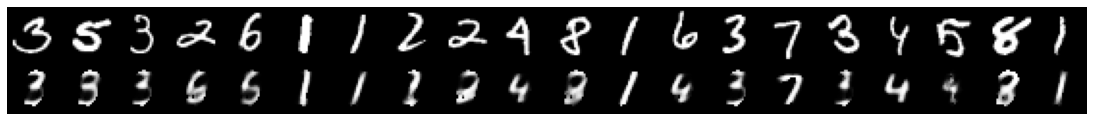

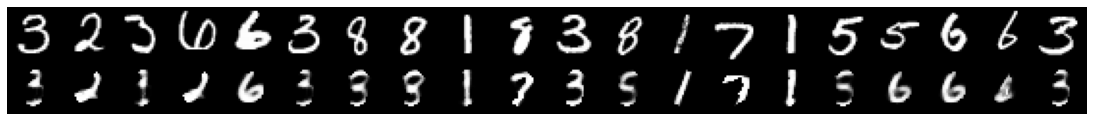

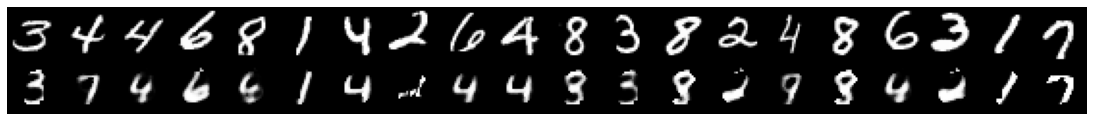

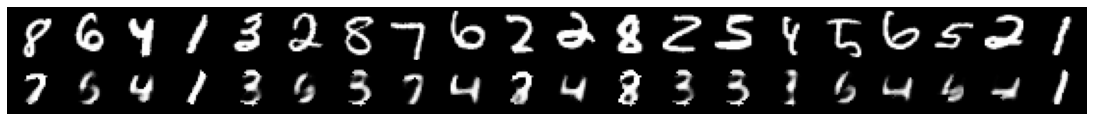

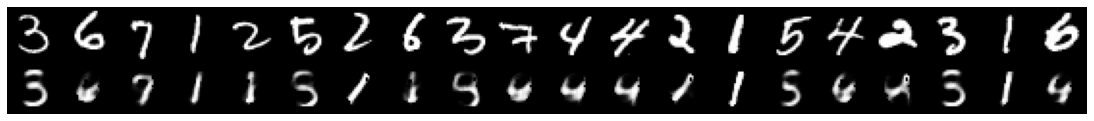

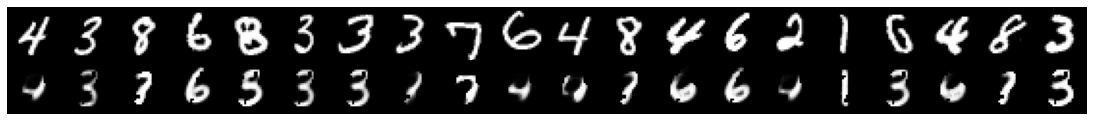

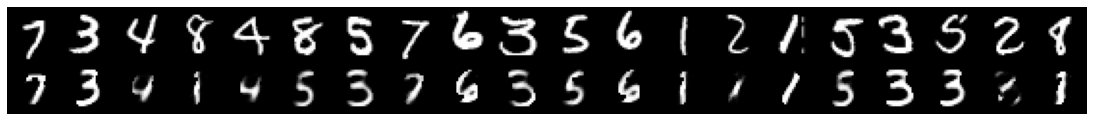

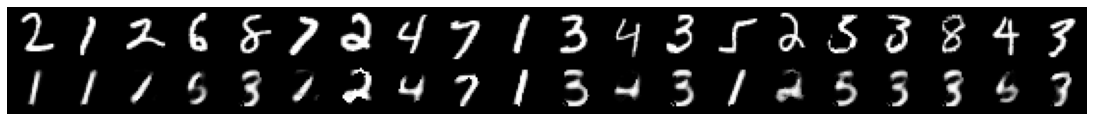

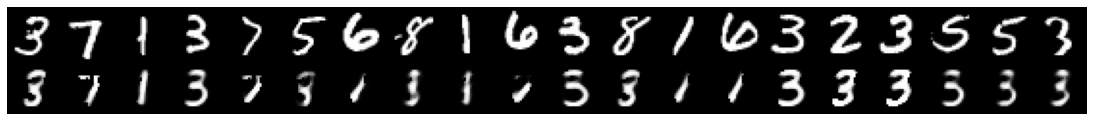

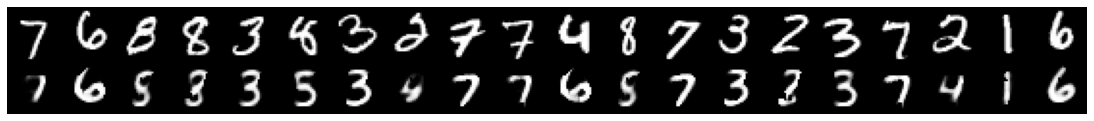

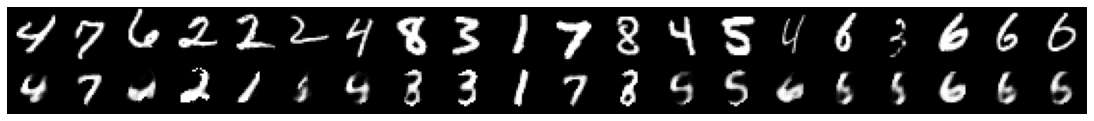

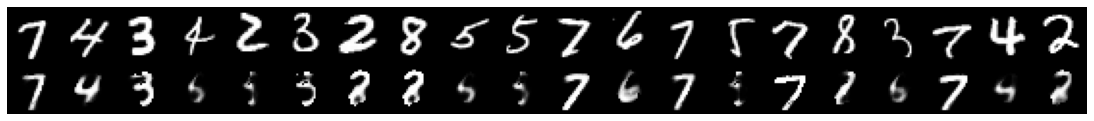

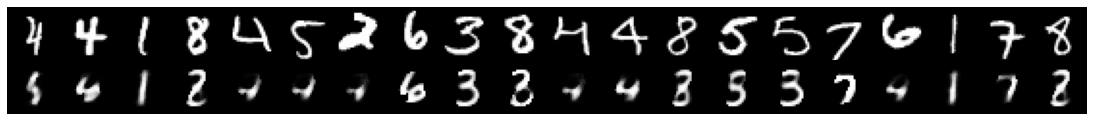

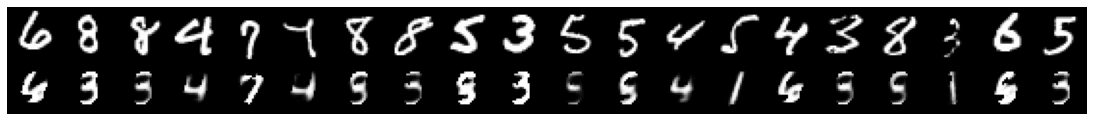

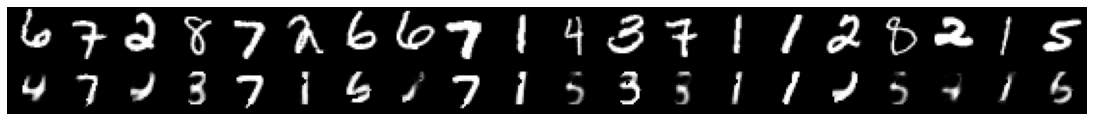

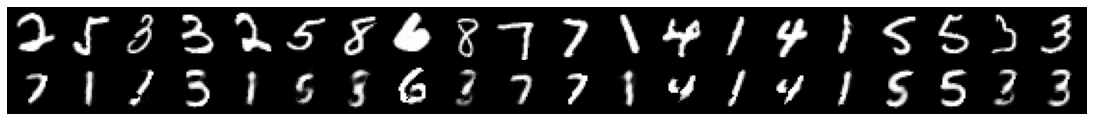

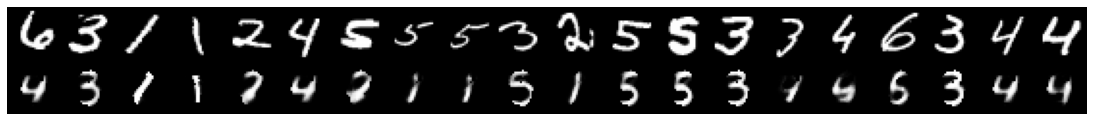

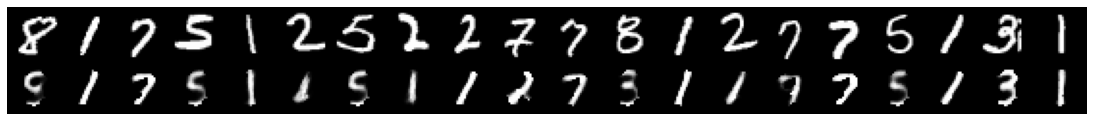

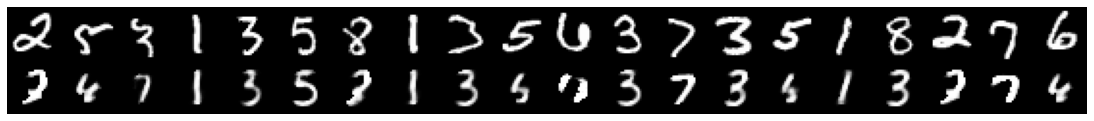

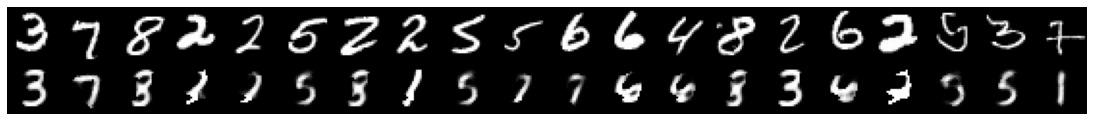

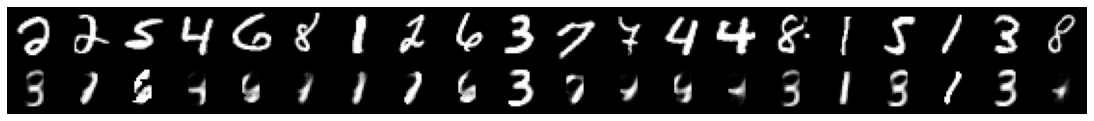

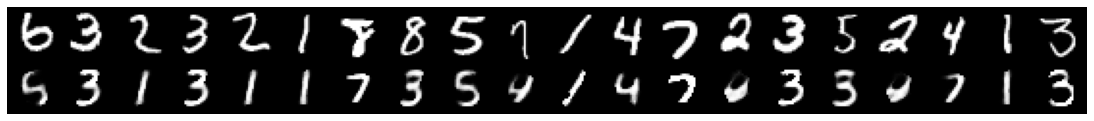

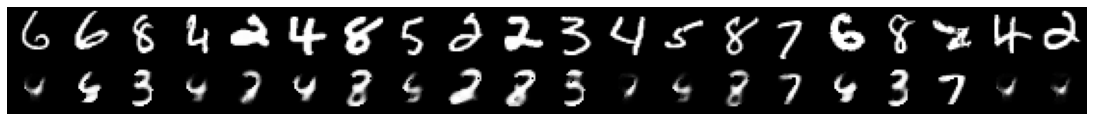

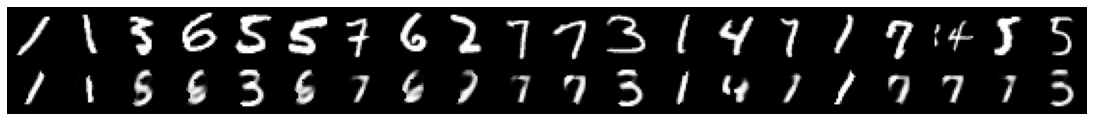

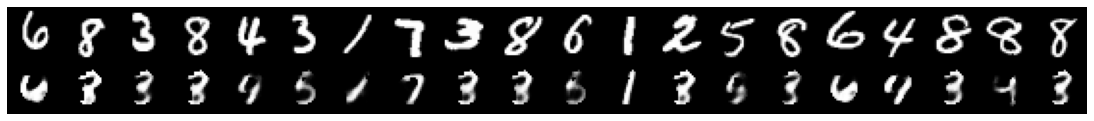

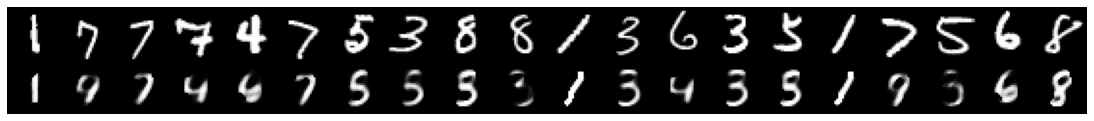

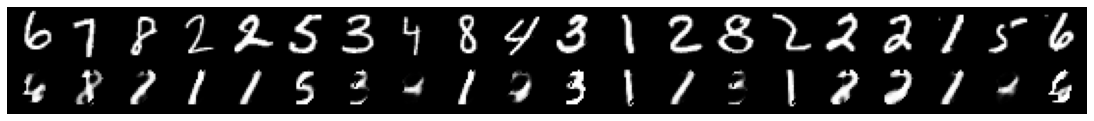

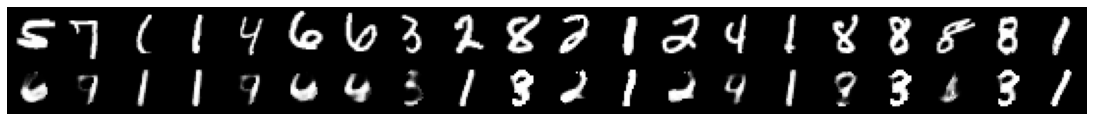

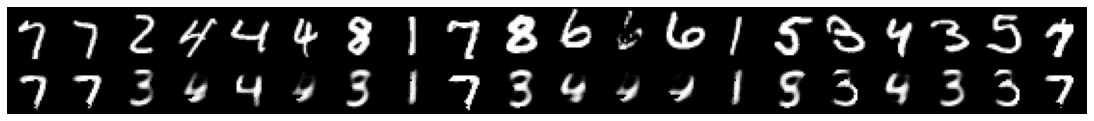

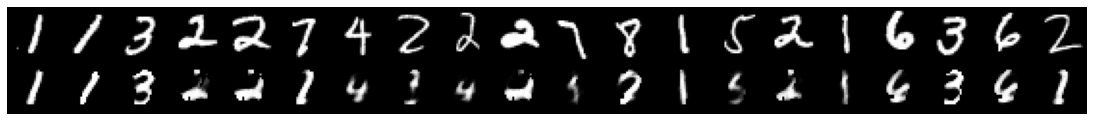

In [7]:
idx = (5, 4, 3, 2)
with torch.no_grad():
    for tid in range(10):
        for j, rad in enumerate(idx):
            path = '../example/runs/MNIST_GM/rad%d_%d/' % (rad, tid)
            vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(path + 'train*.pt'))[-1])
            assert epoch == 40
            joint_dataset_test = MNIST_GM(mnist_pt_path=MNIST_PATH % 'test', data_augment=1, radius=rad)
            test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=400, shuffle=True, drop_last=True)
            for i, data in enumerate(test_loader):
                results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
                break
            x_rec = results['x_rec']
            if isinstance(x_rec[0], torch.distributions.Distribution):
                x_rec = [x_rec[0].loc, x_rec[1].loc]
            ncols = min(len(x_rec[0]), 20)
            fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
            for i, aux in enumerate(zip(data[0], x_rec[0])):
                if i >= ncols:
                    break
                for j, im in enumerate(aux):
                    ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
                    ax[j, i].set_axis_off()
            fig.tight_layout(pad=0)
            fig.savefig(os.path.join('../example/runs/MNIST_GM/', 'poisevae_%d.png' % rad), dpi=300)

In [9]:
# metric = {'model': [], 'radius': [], 'rec_weighting': [], 'val': [], 'cluster ID': []}
metric = {'model': [], 'radius': [], 'distance': [], 'cluster ID': [], 'train ID': []}

idx = (5, 4, 3, 2)
with torch.no_grad():
    for tid in range(10):
        for j, rad in enumerate(idx):
            path = '../example/runs/MNIST_GM/rad%d_%d/' % (rad, tid)
            vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(path + 'train*.pt'))[-1])
            assert epoch == 40
            joint_dataset_test = MNIST_GM(mnist_pt_path=MNIST_PATH % 'test', data_augment=1, radius=rad)
            test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=8000, shuffle=True, drop_last=True)
            for i, data in enumerate(test_loader):
                data[0], data[1] = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
                if i > 0:
                    break
                results = vae(data[:2])
                x_rec = results['x_rec']
                if isinstance(x_rec[0], torch.distributions.Distribution):
                    x_rec = [x_rec[0].loc, x_rec[1].loc]

                for cid in range(1, 9):
                    x1, x2 = x_rec[1][data[-1]==cid].detach(), data[1][data[-1]==cid].detach()
                    c = x2.mean(dim=0)
                    metric['cluster ID'].append(cid)
                    metric['train ID'].append(tid+1)
                    metric['distance'].append(torch.linalg.norm(x1 - c, dim=1).mean().item())
                    metric['model'].append('POISE-VAE')
                    metric['radius'].append(rad)
                    # metric['val'].append([x1.cpu().numpy(), x2.cpu().numpy()])

In [10]:
metric = pd.DataFrame(metric)

In [11]:
metric.to_csv('poise_dist_to_c.csv', index=False)

In [ ]:
# import pickle

# with open("poise_samples.pkl", "wb") as f:
#     pickle.dump(samples, f)